In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pickle
import string
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import add

from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model
from keras_preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from keras_preprocessing.image import img_to_array,load_img


from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
%matplotlib inline

This is a function that extracts features from images in a directory using the VGG16 convolutional neural network. Here's how the function works:

The function takes a directory path as input.
It loads the pre-trained VGG16 model from Keras.
The last layer of the model, which is the classification layer, is removed.
A new model is created that takes the same inputs as the original model, but outputs the second-to-last layer's activations as features.
The function initializes an empty dictionary to store the features.
For each image file in the directory, the function loads the image, resizes it to (224, 224) pixels, converts it to a numpy array, pre-processes the array to match the input format expected by VGG16, and passes it through the model to get the features.
The image's file name, without the extension, is used as a key to store the features in the dictionary.
The dictionary of features is returned by the function.
Finally, the features are pickled and saved to a file.
Note that this function assumes that the images in the directory are in a format that can be loaded by Keras' load_img function, which includes JPEG, PNG, BMP, and GIF formats.

In [4]:
def extract_features(directory):
  model = VGG16()
  model.layers.pop()
  model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
  print(model.summary())
  features = {}
  i=0
  for name in os.listdir(directory):
    print(i)
    img = load_img(directory+'/'+name,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img,verbose=0)
    img_id = name.split('.')[0]
    features[img_id] = feature
    i+=1
  return features

directory ='/content/gdrive/My Drive/Images'
features = extract_features(directory)
filename = '/content/gdrive/My Drive/pickle/features1.pickle'
pickle.dump(features, open(filename, 'wb'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# Load image descriptions from a text file and return a dictionary mapping image IDs to their corresponding descriptions

def load_description(filename):
  mappings = {}
  file = open(filename,'r')
  content = file.readlines()
  file.close()
  for lines in content:
    tokens = lines.split()
    if len(lines)<2:
      continue
    image_id,image_desc = tokens[0].split('.')[0],tokens[1:]
    image_desc = ' '.join(image_desc)
    if image_id not in mappings:
      mappings[image_id] = []
    mappings[image_id].append(image_desc)
  return mappings


# Clean the loaded descriptions by converting them to lowercase, removing punctuation and non-alphabetic characters, and tokenizing them

def clean_description(descriptions):
  table = str.maketrans('','',string.punctuation)
  for k,image_descriptions in descriptions.items():
    for i in range(len(image_descriptions)):
      desc = image_descriptions[i]
      desc = desc.split()
      desc = [x.lower() for x in desc]
      desc = [w.translate(table) for w in desc]
      desc = [x for x in desc if len(x)>1]
      desc = [x for x in desc if x.isalpha()]
      image_descriptions[i] = ' '.join(desc)

# Create a set of unique words from all the cleaned descriptions

def create_corpus(descriptions):
  corpus = set()
  for k in descriptions.keys():
    [corpus.update(x.split()) for x in descriptions[k]]
  return corpus

# Save the cleaned descriptions in a new text file

def save_descriptions(desc,filename):
  lines = []
  for k,v in desc.items():
    for description in v:
      lines.append(k+' '+description)
  data = '\n'.join(lines)
  file = open(filename,'w')
  file.write(data)
  file.close()

# load all descriptions
filename = '/content/gdrive/MyDrive/Caption/itsgonnawork_3.txt'
descriptions = load_description(filename)
print('Descriptions loaded: ',len(descriptions))

# clean the loaded descriptions
clean_description(descriptions)

# check the vocabulary length
vocabulary = create_corpus(descriptions)
print('Vocabulary length: ',len(vocabulary))
save_descriptions(descriptions,'/content/gdrive/MyDrive/Caption/Image_classificationnew.txt')

print('SAVED !!!')

Descriptions loaded:  79
Vocabulary length:  179
SAVED !!!


In [6]:
#This function takes a filename as input and returns a set of image IDs without the file extension.
def load_set_of_image_ids(filename):
  file = open(filename,'r')
  lines = file.readlines()
  file.close()
  image_ids = set()
  for line in lines:
    if len(line)<1:
      continue
    image_ids.add(line.split('.')[0])
  return image_ids

#This function takes the filename containing all descriptions and the set of image IDs for training as input, and returns a dictionary containing cleaned descriptions for the images in the training set.
def load_clean_descriptions(all_desc,train_desc_names):
  file = open(all_desc,'r')
  lines = file.readlines()
  descriptions = {}
  for line in lines:
    tokens = line.split()
    image_id,image_desc = tokens[0].split('.')[0],tokens[1:]
    if image_id in train_desc_names:
      if image_id not in descriptions:
        descriptions[image_id] = []
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      descriptions[image_id].append(desc)
  return descriptions

#This function takes the filename containing image features and the set of image IDs for training as input, and returns a dictionary containing image features for the images in the training set.
def load_image_features(filename,dataset):
  all_features = pickle.load(open(filename,'rb'))
  features = {k:all_features[k] for k in dataset}
  return features

# load train image ids
train = '/content/gdrive/MyDrive/Caption/itsgonnawork_3.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('/content/gdrive/MyDrive/Caption/Image_classificationnew.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

# load training image features
train_features = load_image_features('/content/gdrive/My Drive/pickle/features1.pickle',train_image_ids)
print('training features loaded: ',len(train_features))

train_descriptions

Training images found:  79
training descriptions loaded:  79
training features loaded:  79


{'parte0': ['startseq vehicle going forward and collide in the middle of crossroad endseq',
  'startseq vehicle coming from the right and collide in the middle of crossroad endseq',
  'startseq at crossroad vehicle going forward and in the middle collide with vehicle also going forward endseq',
  'startseq at crossroad vehicle going forward from the left collide against vehicle going forward from the right endseq'],
 'parte1': ['startseq vehicle turning right at tintersection and collide against vehicle in the opposite direction endseq',
  'startseq vehicle going forward invading lane in the opposite direction at tintersection and collide against vehicle endseq',
  'startseq at tintersection vehicle and were coming from opposite direction vehicle turn right and vehicle goes forward and colide endseq',
  'startseq at tintersection vehicle driving forward and invade opposite lane and collide with vehicle turning right endseq'],
 'parte2': ['startseq vehicle driving forward on curve and c

In [7]:
def to_list(descriptions):
  all_desc_list = []
  for k,v in descriptions.items():
    for desc in v:
      all_desc_list.append(desc)
  return all_desc_list

def tokenization(descriptions):
  # list of all the descriptions
  all_desc_list = to_list(descriptions)  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(all_desc_list)
  return tokenizer

# create tokenizer
tokenizer = tokenization(train_descriptions)

# word index is the dictionary /mappings of word-->integer
vocab_size = len(tokenizer.word_index)+1
print('Vocab size: ',vocab_size)

def max_length(descriptions):
  all_desc_list = to_list(descriptions)
  return (max(len(x.split()) for x in all_desc_list))


def create_sequences(tokenizer,desc_list,max_len,photo):
  X1,X2,y = [],[],[]
  # X1 will contain photo
  # X2 will contain current sequence
  # y will contain one hot encoded next word

  for desc in desc_list:
    # tokenize descriptions
    seq = tokenizer.texts_to_sequences([desc])[0]
    for i in range(1,len(seq)):
      # out seq is basically the next word in the sentence
      in_seq,out_seq = seq[:i],seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq],maxlen=max_len)[0]
      # one hot encode output sequence
      out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
      X1.append(photo)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1),np.array(X2),np.array(y)

# maximum length that a description can have OR the biggest description we are having
max_len = max_length(train_descriptions)
print(max_len)

Vocab size:  182
28


In [8]:
def data_generator(descriptions,photos,tokenizer,max_len):
  while 1:
    for k,desc_list in descriptions.items():
      photo = photos[k][0]
      in_img,in_seq,out_seq = create_sequences(tokenizer,desc_list,max_len,photo)
      yield[[in_img,in_seq],out_seq]

def define_model(vocab_size, max_length):
    # image features extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
 
    # input sequence model
    inputs2 = Input(shape=(max_len,))
     # embedding(input_dimension,output_dimension,)
     # input dim is always the vocabulary size 
    # output dimension tells the size of vector space in which the words will be embedded
    # mask zero is used when the input itself is 0 then to not confuse it with padded zeros it is used as True
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model OR output word model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    return model

In [9]:
model = define_model(vocab_size,max_len)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
  generator = data_generator(train_descriptions,train_features,tokenizer,max_len)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('drive/My Drive/image_captioning/model_'+str(i)+'.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 28, 256)      46592       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

<ipython-input-9-a46ee97c60f2>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


79/79 [==============================] - 26s 330ms/step - loss: 0.4071


In [10]:
def int2word(tokenizer,integer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

def predict_desc(model,tokenizer,photo,max_len):
  in_seq = 'startseq'
  for i in range(max_len):
    seq = tokenizer.texts_to_sequences([in_seq])[0]
    seq = pad_sequences([seq],maxlen=max_len)
    y_hat = model.predict([photo,seq],verbose=0)
    y_hat = np.argmax(y_hat)
    word = int2word(tokenizer,y_hat)
    if word==None:
      break
    in_seq = in_seq+' '+word
    if word=='endseq':
      break
  return in_seq

def evaluate_model(model,descriptions,photos,tokenizer,max_len):
  actual,predicted = [],[]
  for key,desc in descriptions.items():
    y_hat = predict_desc(model,tokenizer,photos[key],max_len)
    references = [d.split() for d in desc]
    actual.append(references)
    predicted.append(y_hat.split())
  print('BLEU-1: %f' %corpus_bleu(actual,predicted,weights=(0.25,0,0,0)))
  print('BLEU-2: %f' %corpus_bleu(actual,predicted,weights=(0.25,0.25,0,0)))
  print('BLEU-3: %f' %corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0)))
  print('BLEU-4: %f' %corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))



In [11]:
####################  load training data ##########################
train = '/content/gdrive/MyDrive/Caption/train new.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('/content/gdrive/MyDrive/Caption/Image_classificationnew.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

tokenizer = tokenization(train_descriptions)
max_len = max_length(train_descriptions)

####################  load test data  ##########################
test = '/content/gdrive/MyDrive/Caption/test new.txt'
test_image_ids = load_set_of_image_ids(test)
print('Test images found: ',len(test_image_ids))

# load test descriptions
test_descriptions = load_clean_descriptions('/content/gdrive/MyDrive/Caption/Image_classificationnew.txt',test_image_ids)
print('test descriptions loaded: ',len(test_descriptions))

# load test image features
test_features = load_image_features('/content/gdrive/My Drive/pickle/features1.pickle',test_image_ids)
print('training features loaded: ',len(test_features))
#################################################################
filename = 'drive/My Drive/image_captioning/model_18.h5'
model = load_model(filename)
evaluate_model(model,test_descriptions,test_features,tokenizer,max_len)

Training images found:  70
training descriptions loaded:  70
Test images found:  9
test descriptions loaded:  9
training features loaded:  9
BLEU-1: 0.795348
BLEU-2: 0.457509
BLEU-3: 0.161754
BLEU-4: 0.048974



vehicle tintersection that collide and forward at vehicle to with spot of


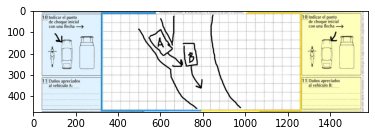

In [21]:
img_to_test = '/content/gdrive/MyDrive/Images/parte6.jpg'
img = plt.imread(img_to_test)
plt.imshow(img)

def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# pre-define the max sequence length (from training)
max_length = 28
# load the model
model = load_model('drive/My Drive/image_captioning/model_18.h5')
# load and prepare the photograph
photo = extract_features(img_to_test)
# generate description
description = predict_desc(model, tokenizer, photo, max_length)

description = ' '.join(description.split()[1:-1])
print()
print(description)
